In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import mdtraj as md
import scipy.stats as scs
from scipy.optimize import curve_fit
import string
import multiprocessing as mp

In [26]:
def fix_topology(t,seq):
    cgtop = md.Topology()
    cgchain = cgtop.add_chain()
    for res in seq:
        cgres = cgtop.add_residue(res, cgchain)
        cgtop.add_atom('CA', element=md.element.carbon, residue=cgres)
    traj = md.Trajectory(t.xyz, cgtop, t.time, t.unitcell_lengths, t.unitcell_angles)
    traj = traj.superpose(traj, frame=0)
    return traj

def kde(a, w=None):
    if w is None:
        w = np.full(len(a), 1)
    min_ = np.min(a)
    max_ = np.max(a)
    x = np.linspace( min_, max_, num = 50 )
    d = scs.gaussian_kde( a, bw_method = "silverman", weights = w ).evaluate(x)
    u = 1./np.average(1./a, weights = w)
    return x,d,u

def Stejskal_Tanner(G, D, I0):
    I = I0*np.exp( -(G*gamma*delta[p])**2 *(dt[p]-(delta[p]/3))*D )
    return I

def calcRs(traj):
    pairs = traj.top.select_pairs('all','all')
    d = md.compute_distances(traj,pairs)
    dmean = d.mean(axis=0)
    ij = np.array(range(1,traj.n_atoms))
    diff = [x[1]-x[0] for x in pairs]
    dij = np.empty(0)
    for i in ij:
        dij = np.append(dij,dmean[diff==i].mean())
    return ij, dij, d.max()

### Calculation of NMR diffusion profiles from calculated $R_h$

In [52]:
gamma = 26752
dt = {'aSyn':0.2, 'GHR-ICD':0.299, 'NHE6cmdd':0.2, 'ANAC046':0.2, 'DSS1':0.2, 'A1':0.05}
delta = {'aSyn':0.003, 'GHR-ICD':0.003, 'NHE6cmdd':0.002, 'ANAC046':0.003, 'DSS1':0.003, 'A1':0.006}

In [53]:
G ={
    'aSyn': np.array([0.963,4.045,7.126,10.208,13.289,16.371,19.453,22.534,25.616,28.697,31.779,34.861,37.942,41.024,44.105,47.187]),
    'GHR-ICD': np.array([1.034,2.636,4.237,5.839,7.441,9.042,10.644,12.245,13.847,15.448,17.05,18.651,20.253,21.854,23.456,25.058,26.659,28.261,29.862,31.464,33.065,34.667,36.268,37.87,39.471,41.073,42.675,44.276,45.878,47.479,49.081,50.682]),
    'NHE6cmdd': np.array([2.541,4.066,5.591,7.115,8.64,10.165,11.69,13.214,14.739,16.264,17.789,19.313,20.838,22.363,23.888,25.412,26.937,28.462,29.987,31.511,33.036,34.561,36.086,37.61,39.135,40.66,42.185,43.709,45.234,46.759,48.284,49.808]),
    'ANAC046': np.array([2.407,3.805,5.203,6.601,7.999,9.397,10.795,12.193,13.591,14.989,16.387,17.784,19.182,20.58,21.978,23.376,24.774,26.172,27.57,28.968,30.366,31.763,33.161,34.559,35.957,37.355,38.753,40.151,41.549,42.947,44.345,45.742]),
    'DSS1': np.array([0.963,2.454,3.945,5.436,6.927,8.418,9.91,11.401,12.892,14.383,15.874,17.365,18.856,20.347,21.838,23.329,24.821,26.312,27.803,29.294,30.785,32.276,33.767,35.258,36.749,38.24,39.732,41.223,42.714,44.205,45.696,47.187]),
    'A1': np.array([3.118,4.009,4.901,5.791,6.683,7.573,8.465,9.355,10.246,11.138,12.028,12.92,13.81,14.702,15.592,16.483,17.375,18.265,19.157,20.047,20.939,21.829,22.72,23.612,24.502,25.394,26.284,27.176,28.066,28.957,29.849,30.739,31.631,32.521,33.413,34.303,35.194,36.086,36.976,37.868,38.758,39.65,40.541,41.431,42.323,43.213,44.105,44.995,45.887,46.777,47.668,48.56,49.45,50.342,51.232,52.124,53.014,53.905,54.797,55.687,56.579,57.469,58.361,59.251])
}
I_exp = {
    'aSyn': np.array([15485266,15773410,15229786,14478059,13266520,11998732,10662664,9460325,8374958,7217384,6054632,5067632,4090203,3362176,2673208,2055151]),
    'GHR-ICD': np.array([2657880290,2649679346,2621386065,2580174595,2527466423,2464829491,2391779737,2311497967,2219988332,2123731998,2021780791,1914600698,1808887696,1695485357,1584025836,1473229963,1361390894,1254453367,1151014157,1051131324,954070868,863560116,776331202,695979453,622439550,552844528,488338566,430531246,373911173,326378402,283671314,246048160]),
    'NHE6cmdd': np.array([189673089,190719084,191039607,191696124,191746521,189326340,188363525,185963654,182791344,179601143,175895800,172018057,168094745,163026936,158443558,153552069,148653244,143483370,138234661,132593947,127452554,121870895,116764692,111706713,105868703,100488831,95285914,90344539,85392329,80677400,75903939,71329065]),
    'ANAC046': np.array([1172931954,1163885576,1148561250,1129484395,1106199940,1078542397,1046812580,1012427828,975346103,935705918,894137388,851134693,806087369,761098874,715933167,670114206,625116185,580346257,537183787,495441814,454894006,415771356,379199167,344354844,311073767,279892643,251045573,225278392,201335366,178255369,157451162,138220100]),
    'DSS1': np.array([17910971,22663666,22995111,23800033,23450476,22953424,22795260,22246247,21620288,20723685,19798965,18877471,17876315,16610970,15805626,14748818,13770825,12706859,11626993,10733501,9804229,8806014,8021584,7226058,6521615,5849572,5167463,4592657,4027360,3559010,3026038,2621577]),
    'A1': np.array([1498344,1426554,812166,1420171,1453658,1411849,1338216,1383376,1358333,1300368,1291459,1262169,1134842,1193897,1106124,1092066,1060529,1051596,994116,967744,939030,901163,862031,830736,794375,756093,715883,680516,664466,609423,582110,560653,507561,487641,459608,439792,419926,393159,356663,342118,309326,281633,267263,246428,230792,210993,201672,185730,171361,148959,134806,121855,112488,104330,95003,92470,80904,76802,68984,57936,51891,44953,44667,31722])
}
I_DIOX = {
    'aSyn': np.array([2299859099,1895194598,1229809021,630187265,255736074,82511497,21089231,4225036,568381,115534,101068,-112,161092,107924,97165,93281]),
    'GHR-ICD': np.array([3074192032,2687696634,2094015310,1450774054,899113617,501090653,254785590,122150601,58578983,31731902,21412760,16963645,15380873,14206822,13070587,11964036,11019466,9869343,8947559,8070727,7510034,6432460,5967473,5164268,4815424,3994737,3434195,3146770,2153713,1851541,1329802,1112463]),
    'NHE6cmdd': np.array([1695847669,1613141097,1496920302,1357058064,1201736713,1037902316,876026174,722504338,581684970,458531896,353177976,266006671,195919622,141572665,99941333,69064246,46852485,31488952,20713042,13439199,8457779,5397121,3592429,2430280,1693820,999380,764906,653125,453563,305422,449028,262261]),
    'ANAC046': np.array([2893867470,2543013503,2104997289,1643788838,1211913722,845251334,559572260,352679794,213322292,124977350,72946585,43656702,27775090,19593842,15298874,12965865,11436147,10212647,9594086,8728759,7859863,7257331,6506761,5859863,5361654,4768258,3915039,3514684,3301326,2867403,2592893,2257151]),
    'DSS1': np.array([1976940225,1919921996,1788359023,1612582558,1403964990,1184456815,970799235,768398908,589301860,437208697,314705170,219193937,147957040,96229750,61563280,37794499,22763840,13044738,7182998,3998089,2108558,1078974,490513,205761,61266,-22062,-26158,-67636,-27460,-66588,-82522,-94122]),
    'A1': np.array([76146368,70764613,50306271,59138165,51773471,44825152,38233810,32038574,26209806,21390413,17003661,13248740,10147066,7752926,5736628,4328185,3235681,2324664,1714792,1264032,935831,718549,553020,451766,368299,314279,272411,245774,220900,200538,184962,179844,179104,134819,147239,135677,125250,117761,116764,91553,89951,87864,93383,73379,59718,65411,58536,56837,50270,47683,36519,22442,24031,30875,8680,16700,19836,13847,23344,16679,14119,3107,8238,4780])
}

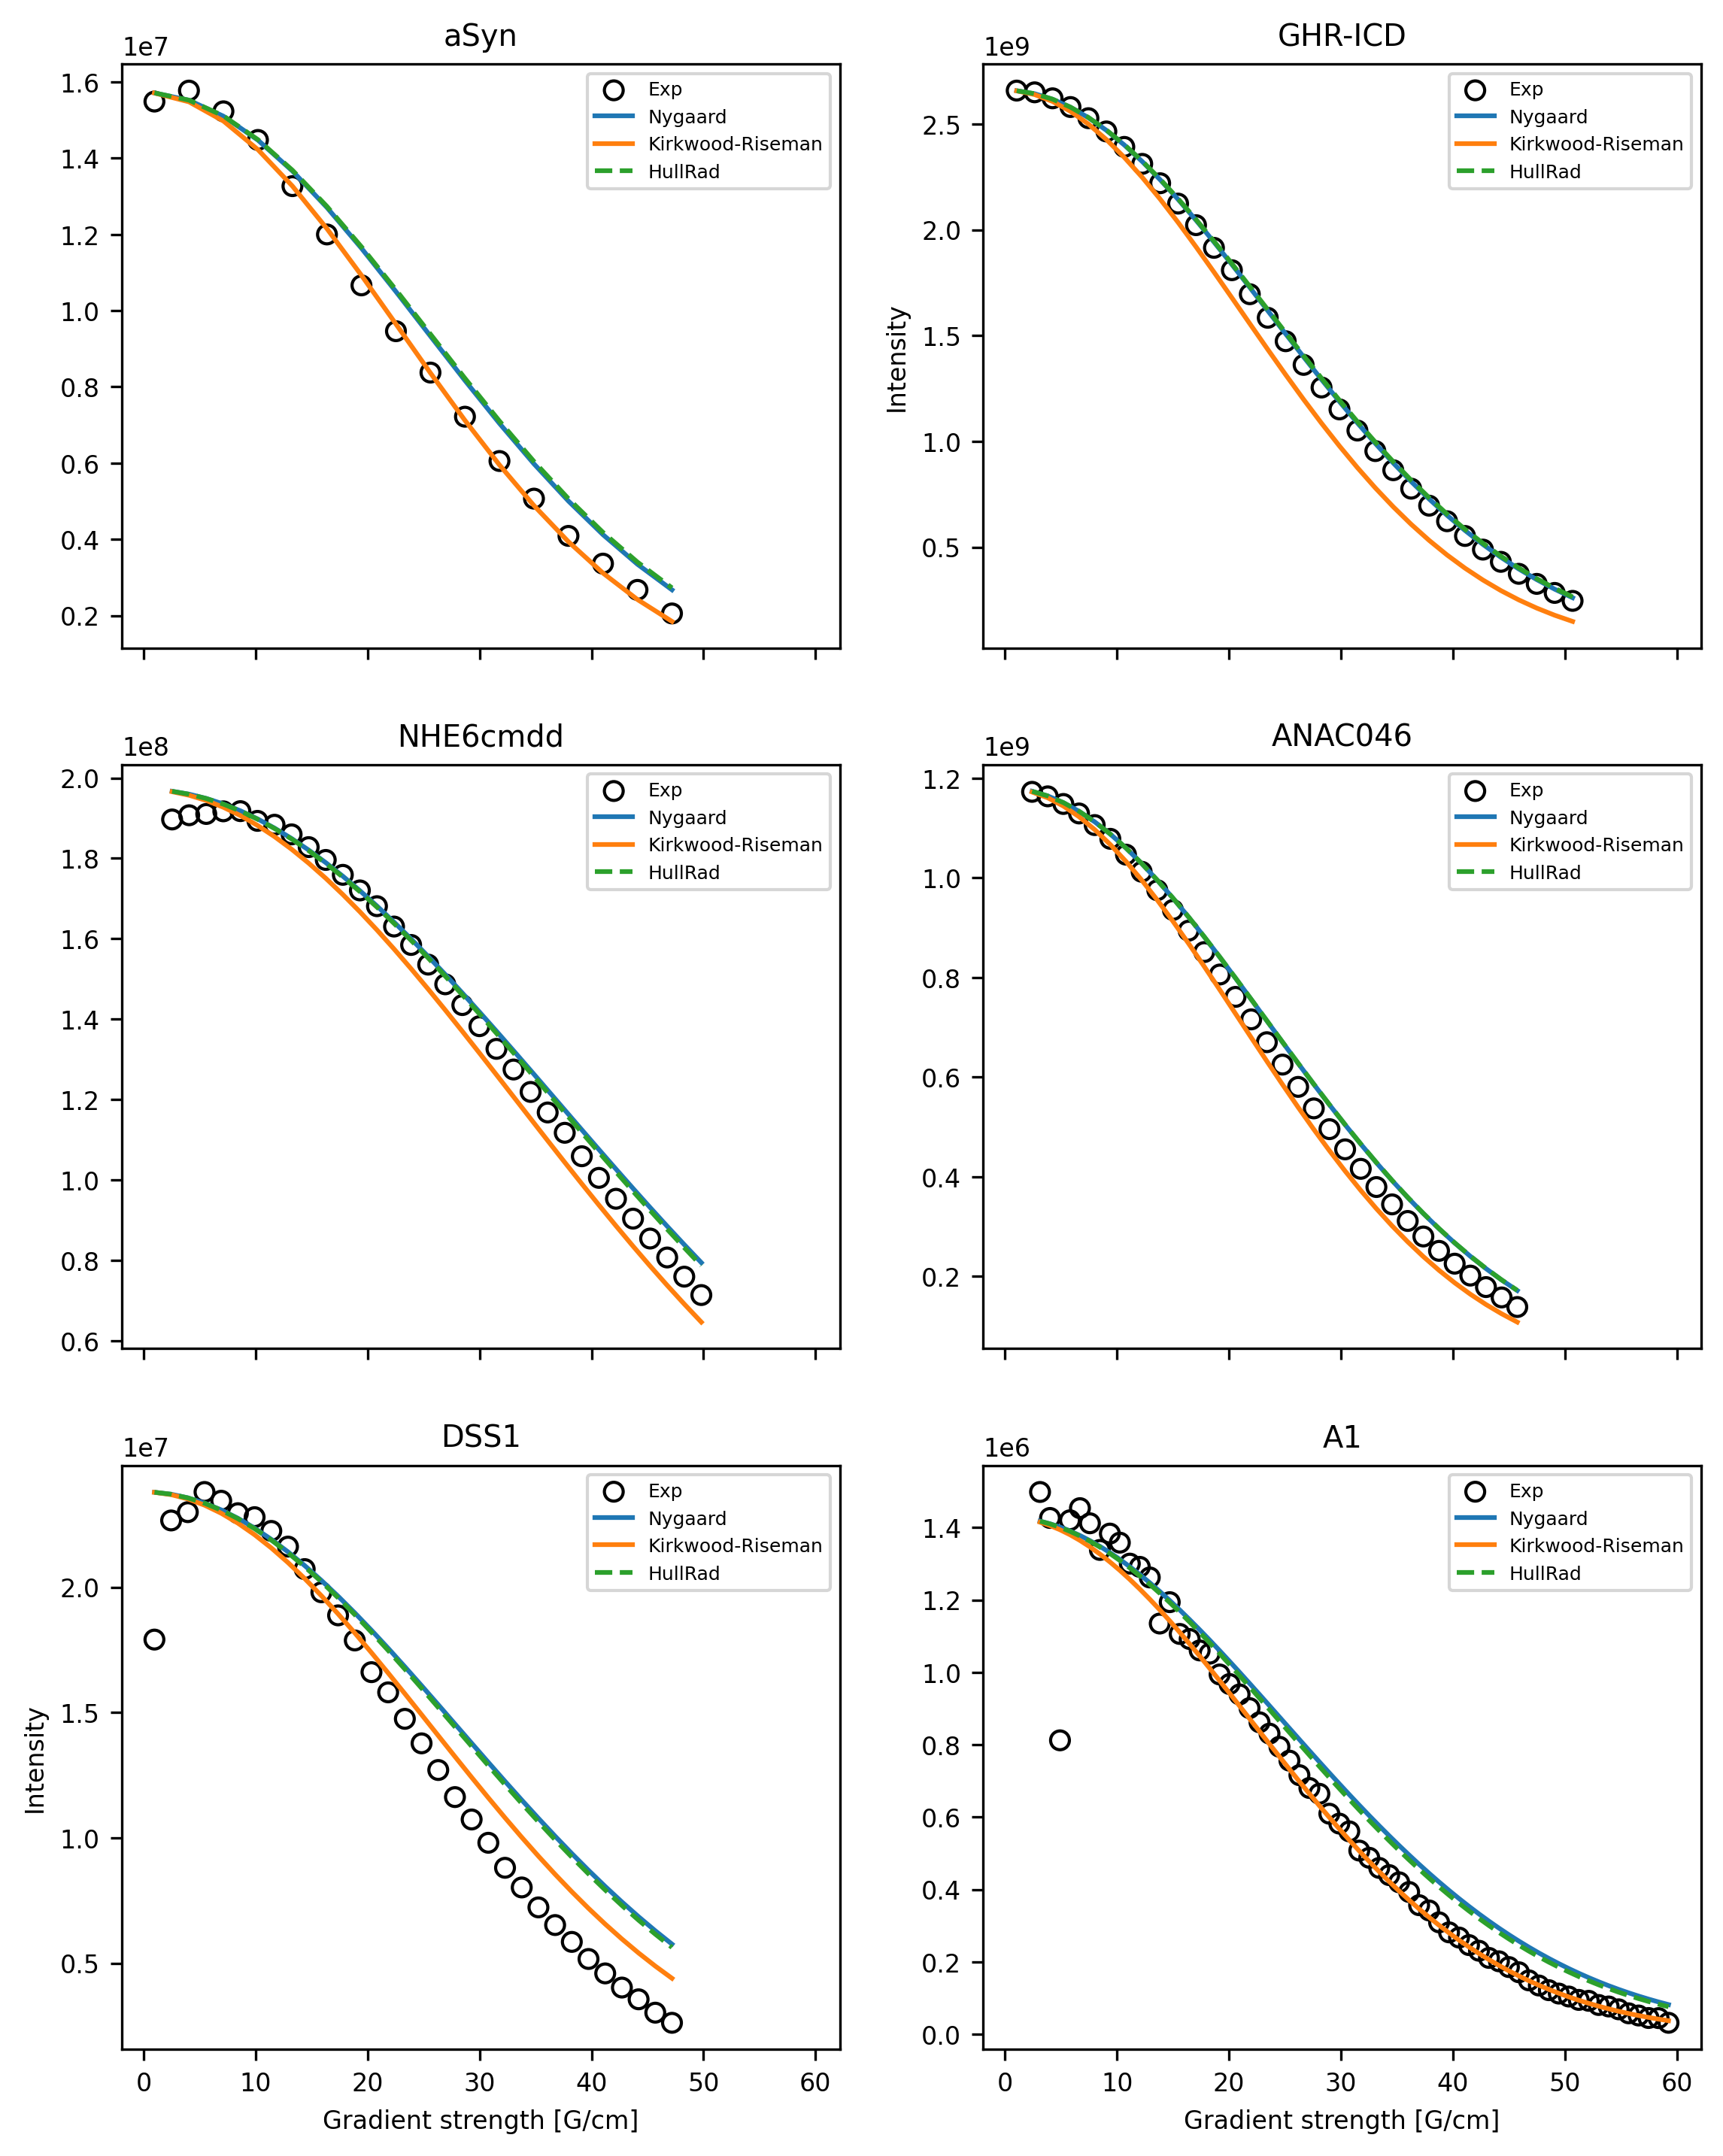

In [71]:
mpl.rcParams.update({'font.size': 8})
fig, axs = plt.subplots(3, 2, figsize=(5,8), facecolor='w', dpi=300,sharex=True)

for p,ax in zip(G.keys(), axs.flatten()):
    poptD, _ = curve_fit(Stejskal_Tanner, G[p], I_DIOX[p], p0=[0.000001, I_DIOX[p][0]])
    poptP, _ = curve_fit(Stejskal_Tanner, G[p], I_exp[p], p0=[0.000001, I_exp[p][0]])
        
    Dp_Kirk = 0.212*poptD[0]/Rh_Kirk[p][2]
    Dp_HR = 0.212*poptD[0]/Rh_HR[p][2]
    Dp_Nyg = 0.212*poptD[0]/Rh_Nyg[p][2]
    
    ax.scatter(G[p], I_exp[p],edgecolors='k',label='Exp',facecolor='none')
    ax.plot(G[p], Stejskal_Tanner(G[p], Dp_Nyg, poptP[1]), label='Nygaard')
    ax.plot(G[p], Stejskal_Tanner(G[p], Dp_Kirk, poptP[1]),label='Kirkwood-Riseman')
    ax.plot(G[p], Stejskal_Tanner(G[p], Dp_HR, poptP[1]), label='HullRad', ls='dashed')
    ax.legend(fontsize=6)
    
    ax.set_title(p)
    
axs.flatten()[1].set_ylabel(r'Intensity')
axs.flatten()[4].set_ylabel(r'Intensity')
axs.flatten()[-1].set_xlabel(r'Gradient strength [G/cm]')    
axs.flatten()[-2].set_xlabel(r'Gradient strength [G/cm]')    

plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=1.5, 
                    top=1.2, 
                    wspace=0.2, 
                    hspace=0.2)
plt.savefig('diff_prof.pdf', dpi=300, facecolor='w', edgecolor='w', orientation='portrait', bbox_inches='tight')
plt.show()

### What if $R_h$ of dioxane is different?

In [148]:
dataset_ori = pd.read_csv('/storage1/francesco/PROJECTS/EXP_DATA/Rh.csv').set_index('name')
dataset_ori['Rh_err'] = dataset_ori['Rh']*0.020915743348596486

In [47]:
scale = np.arange(0.8,1.5,0.01)

In [83]:
Rh_Nyg = {}
Rh_Kirk = {}
Rh_HR = {}
Rh_KirkNyg = {}
for p in dataset_ori.index:
    Rh_Nyg[p] = kde( np.loadtxt(p+'/Rh_Nyg.dat')/10 )
    Rh_Kirk[p] = kde( np.loadtxt(p+'/Rh_Kirk_Ca.dat') )
    Rh_HR[p] = kde( np.loadtxt(p+'/Rh_HR.dat'))
    Rh_KirkNyg[p] = kde( np.loadtxt(p+'/Rh_Kirk_Ca.dat')*1.186+0.103 )

In [50]:
kirk_chi2 = []
nyg_chi2 = []
hr_chi2 = []
for f in scale:
    chi2 = ([v[2] for x,v in Rh_Kirk.items()] - dataset_ori.Rh.values*f)**2 / (dataset_ori.Rh_err.values*f)**2
    kirk_chi2.append(chi2.sum())
    
    chi2 = ([v[2] for x,v in Rh_Nyg.items()] - dataset_ori.Rh.values*f)**2 / (dataset_ori.Rh_err.values*f)**2
    nyg_chi2.append(chi2.sum())
    
    chi2 = ([v[2] for x,v in Rh_HR.items()] - dataset_ori.Rh.values*f)**2 / (dataset_ori.Rh_err.values*f)**2
    hr_chi2.append(chi2.sum())

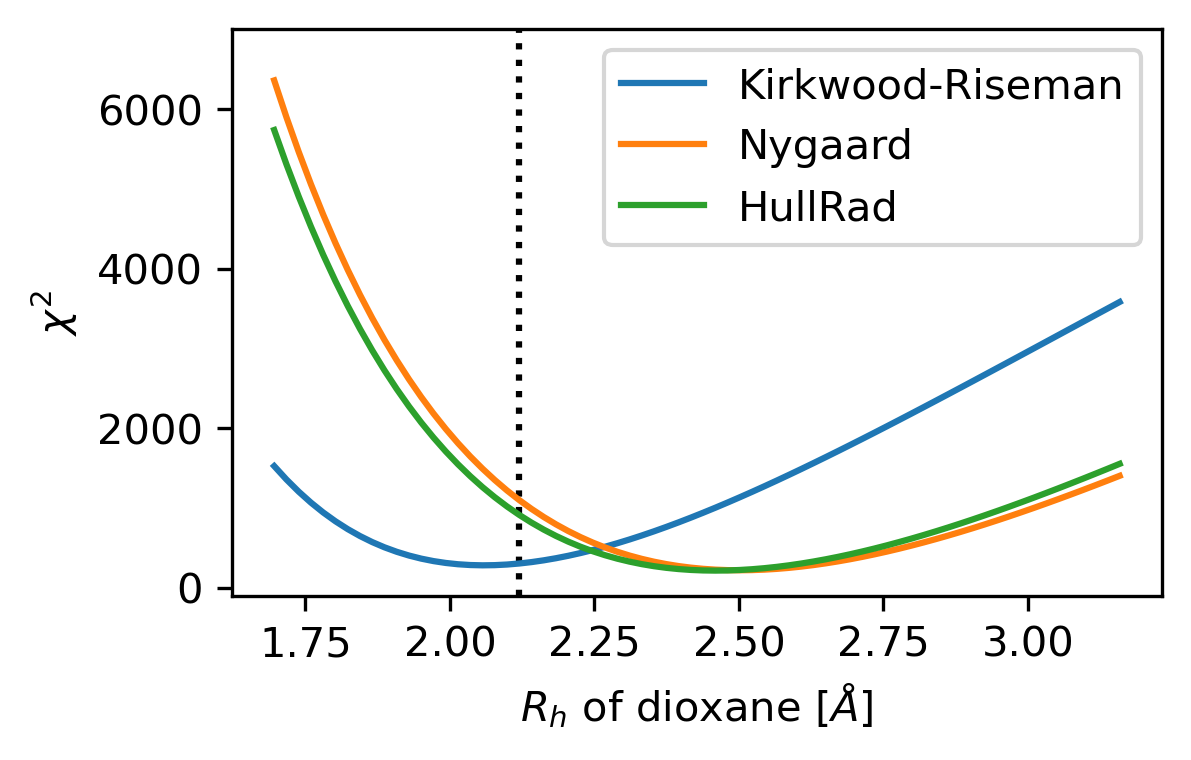

In [51]:
fig, ax = plt.subplots(figsize=(4,2.5), dpi=300)

plt.vlines(2.12,-100,7000,color='k',ls='dotted')

plt.plot(scale*2.12, kirk_chi2,label='Kirkwood-Riseman')
plt.plot(scale*2.12, nyg_chi2,label='Nygaard')
plt.plot(scale*2.12, hr_chi2,label='HullRad')

plt.xlabel(r'$R_h$ of dioxane [$\AA$]')
plt.ylabel(r'$\chi^2$')
plt.ylim(-100,7000)

plt.legend()

plt.savefig('scale_rh_diox.pdf', dpi=300, facecolor='w', edgecolor='w', orientation='portrait', bbox_inches='tight')

## Changes in R$_h$ upon PULCHRA conversion

In [7]:
def generate_dummy_trajectory(traj,xyz):
    """Convert xyz coordinates and box vectors into an MDTraj Trajectory (with Topology)."""

    n_atoms = np.shape(xyz)[1]
    data = []

    for i in range(n_atoms):
        data.append(dict(serial=i, name="CA", element="C", resSeq=i + 1, resName="UNK", chainID=0))

    data = pd.DataFrame(data)
    unitcell_lengths = traj.unitcell_lengths
    unitcell_angles = traj.unitcell_angles
    top = md.Topology.from_dataframe(data, np.zeros((0, 2), dtype='int'))
    traj = md.Trajectory(xyz, top, unitcell_lengths=unitcell_lengths, unitcell_angles=unitcell_angles)

    return traj

def generate_cm_traj(traj):
    c_xyz = []
    for res in range(len(list(traj.topology.residues))):
        atoms = traj.top.select("residue {}".format(res))
        #c_xyz.append(md.compute_center_of_mass(traj.atom_slice(atoms)))
        c_xyz.append(md.compute_center_of_geometry(traj.atom_slice(atoms)))
    c_xyz = np.swapaxes(np.array(c_xyz),0,1)
    c_traj = generate_dummy_trajectory(traj,c_xyz)
    return c_traj

def rh_kirk(conf):
    n=len(list(conf.top.residues))
    invrij = (1-1/n)*(1/md.compute_distances(conf,conf.top.select_pairs('all','all'))).mean(axis=1)
    return 1/invrij

In [109]:
rh_beads = {}
rh_aa_com = {}

In [113]:
for p in dataset_ori.index:
    traj_beads = md.load_dcd('/storage1/francesco/PROJECTS/ENSEMBLES/TSCL-M1/{}/traj.dcd'.format(p), top='/storage1/francesco/PROJECTS/ENSEMBLES/TSCL-M1/{}/top.pdb'.format(p))[0::10]
    traj_aa = md.load_dcd('/storage1/francesco/PROJECTS/ENSEMBLES/TSCL-M1/{}/traj_AA.dcd'.format(p), top='/storage1/francesco/PROJECTS/ENSEMBLES/TSCL-M1/{}/frame0.pdb'.format(p))
    traj_aa_com = generate_cm_traj(traj_aa)
    
    rh_beads[p] = rh_kirk(traj_beads)
    rh_aa_com[p] = rh_kirk(traj_aa_com)

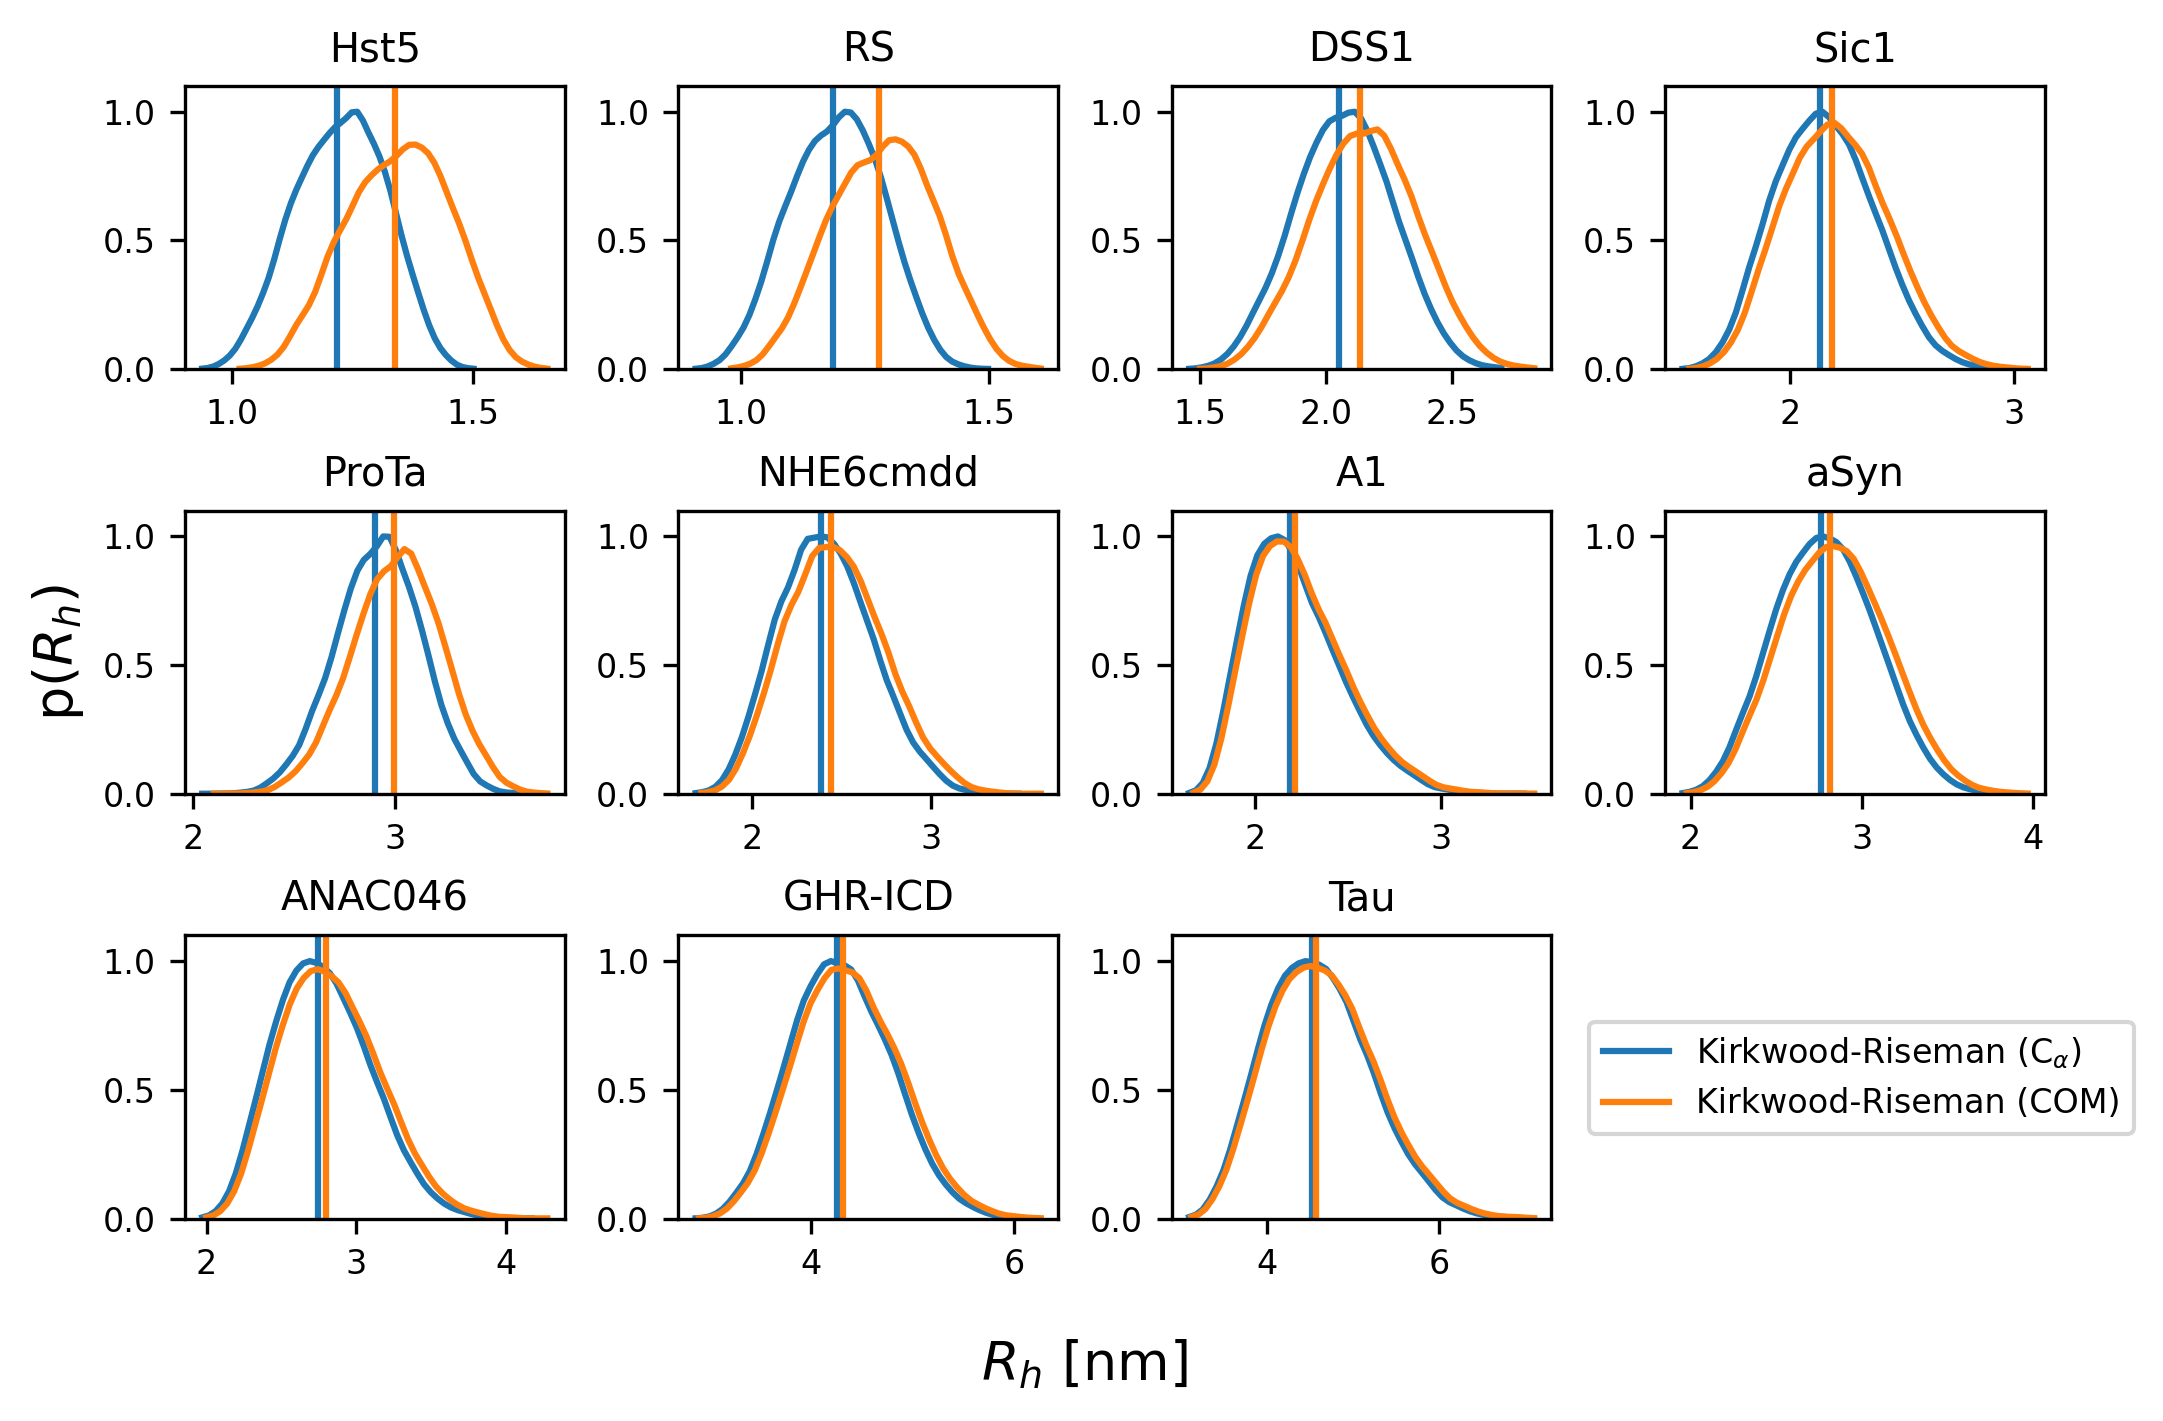

In [151]:
fig, axs = plt.subplots(3, 4, figsize=(8,5), facecolor='w', dpi=300)
for p,ax in zip(dataset_ori.index, axs.flatten()):
    _=kde(rh_beads[p])
    scale = np.max(_[1])
    ax.plot(_[0],_[1]/scale,label=r'Kirkwood-Riseman (C$_\alpha$)')
    ax.vlines(_[2],0,2,color='tab:blue')
    
    _=kde(rh_aa_com[p])
    ax.plot(_[0],_[1]/scale, label='Kirkwood-Riseman (COM)')
    ax.vlines(_[2],0,2,color='tab:orange')

    #ax.legend(loc='upper right', fontsize=8)
    ax.set_title(p)
    ax.set_ylim(0,1.1)    
    
axs[-1,-1].axis('off')
axs.flatten()[4].set_ylabel(r'p($R_h$)', fontsize=13)
fig.supxlabel(r'$R_h$ [nm]', fontsize=13)

plt.subplots_adjust(wspace=0.3, 
                    hspace=0.5)

axs.flatten()[-2].legend(fontsize=8, loc=(1.1,0.3))
    
plt.savefig('kirk_ca_com.pdf', dpi=300, facecolor='w', edgecolor='w', orientation='portrait', bbox_inches='tight')

In [139]:
w = {}
for p in dataset_ori.index:
    w[p] = np.loadtxt('w_{}.dat'.format(p))

In [150]:
chi2 = ([kde(rh_beads[p],w = w[p])[2] for p in dataset_ori.index] - dataset_ori.Rh.values)**2 / (dataset_ori.Rh_err.values)**2
print ('Kirkwood', chi2.sum())

Kirkwood 188.52402653280004


In [149]:
chi2 = ([kde(rh_aa_com[p],w = w[p])[2] for p in dataset_ori.index] - dataset_ori.Rh.values)**2 / (dataset_ori.Rh_err.values)**2
print ('Kirkwood', chi2.sum())

Kirkwood 232.17162736860038


### Homopolymer analysis

In [27]:
def rg_rh(aa):
    t = md.load('homop/{}/traj.dcd'.format(aa), top='homop/{}/top.pdb'.format(aa))[0::10]
    rg = md.compute_rg(t)
    rh = rh_kirk(t)
    np.save('{}_dat'.format(aa), np.array([rg,rh]))
    
    rs = calcRs(t)
    np.save('Rs_{}'.format(aa),rs)

In [28]:
aa = ['A','C','F','G','H','I','L','M','N','P','Q','S','T','V','W','Y']
pool = mp.Pool(len(aa))
pool.map(rg_rh, aa)
pool.close()
pool.join()

/storage1/francesco/software/miniconda3/lib/python3.9/site-packages/numpy/lib/npyio.py:518: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)
/storage1/francesco/software/miniconda3/lib/python3.9/site-packages/numpy/lib/npyio.py:518: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)
/storage1/francesco/software/miniconda3/lib/python3.9/site-packages/numpy/lib/npyio.py:518: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with 

In [92]:
ratio = []
for a in aa:
    _ = np.load('{}_dat.npy'.format(a), allow_pickle=True)
    ratio.append( ((_[0]**2).mean())**(1/2) * (_[1]**(-1)).mean() )

In [93]:
r0_fix = 0.68
nu = []
f = lambda x,v : r0_fix*np.power(x,v)
for a in aa:
    ij, dij, dmax = np.load('Rs_{}.npy'.format(a),allow_pickle=True)
    popt, pcov = curve_fit(f,ij[ij>10],dij[ij>10],p0=[.5])
    nu.append(popt[0])

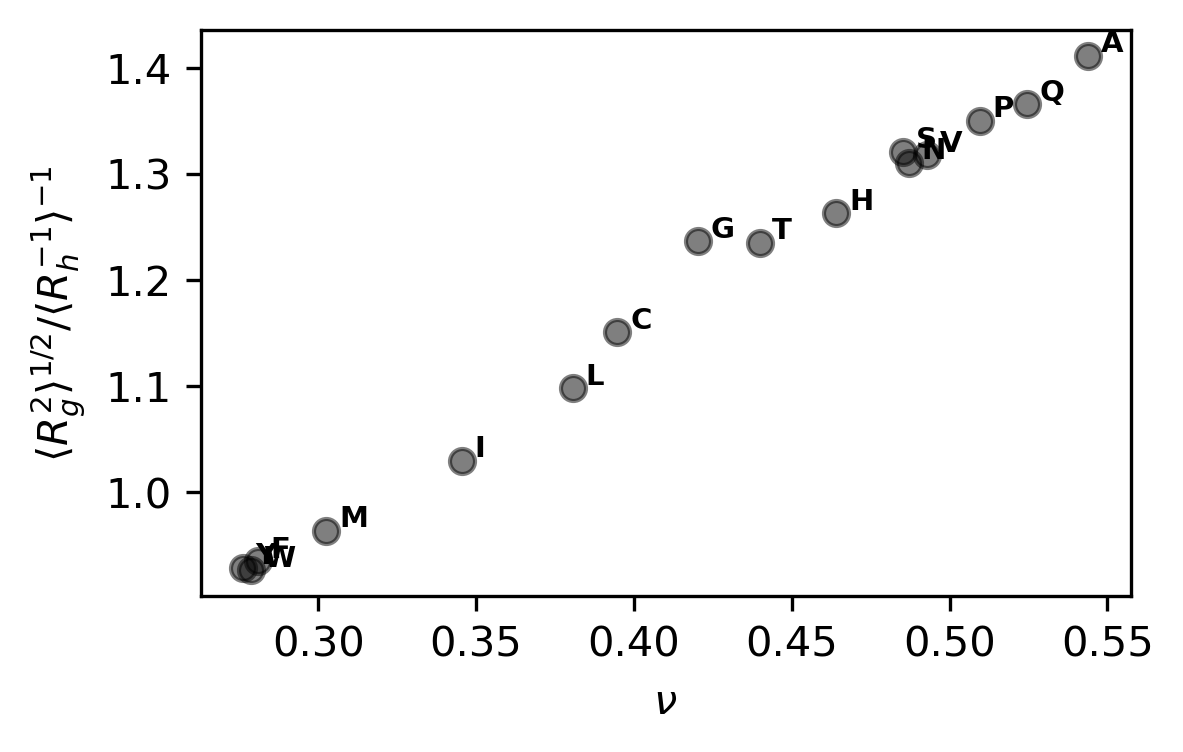

In [99]:
fig, ax = plt.subplots(figsize=(4,2.5), dpi=300,facecolor='w')

markers = ["${}$".format(m) for m in aa]
plt.scatter(nu,ratio,c='k',edgecolor='k',alpha=0.5)
#for i,a in enumerate(aa):
    #plt.scatter(nu[i], ratio[i], marker='${}$'.format(a),color='k',edgecolor='w',lw=0.01)
for i, txt in enumerate(aa):
    plt.annotate(txt, (nu[i]+0.004, ratio[i]+0.004), fontsize=7, fontweight='bold', color='k')
plt.ylabel(r'$\langle R_g^2 \rangle^{1/2}/ \langle R_h^{-1} \rangle^{-1}$')
plt.xlabel(r'$\nu$')

plt.savefig('ratio_nu.pdf', dpi=300, facecolor='w', edgecolor='w', orientation='portrait', bbox_inches='tight')